# Homework 2 Validation
**Due Date: 10/30/2017**

Name: Gosuddin Siddiqi<br>
Student Number: 1627383

In [2]:
# import PyPlot to plot
using PyPlot

## Load Data and Define Functions

In [3]:
# function that read data
function readdata(filename, datatype, dsize)
    fid = open(filename, "r");
    data = read(fid, datatype, dsize);
    close(fid);
    return data
end
# function used for model assessment
function logloss(x, f, s)
    r = f*x;
    val = 0.0;
    for I in eachindex(r)
        p = 1.0/(1.0+exp(-r[I]));
        s[I] == 1 ? val += -log(p) : val += -log(1-p);
    end
    return val/length(s)
end

logloss (generic function with 1 method)

In [4]:
# read data
n_features = 50;
m_train = 2000;
m_validate = 500;
m_test = 500;

train_f = readdata("numerai_datasets/train_features.bin", Float64, m_train*n_features);
train_s = readdata("numerai_datasets/train_target.bin", Float64, m_train);
validate_f = readdata("numerai_datasets/validate_features.bin", Float64, m_validate*n_features);
validate_s = readdata("numerai_datasets/validate_target.bin", Float64, m_validate);
test_f = readdata("numerai_datasets/test_features.bin", Float64, m_test*n_features);
test_s = readdata("numerai_datasets/test_target.bin", Float64, m_test);

train_f = reshape(train_f, m_train, n_features);
validate_f = reshape(validate_f, m_validate, n_features);
test_f = reshape(test_f, m_test, n_features);

train_f = train_f./sqrt(sumabs2(train_f,1));
validate_f = validate_f./sqrt(sumabs2(validate_f,1));
test_f = test_f./sqrt(sumabs2(test_f,1));

## Define Function for Smooth Part of Logistic Regression
$$\text{lgr}(x) = \sum_{i=1}^m\left\{\log\left(1+\exp{\left\langle f_i, x\right\rangle}\right) - s_i\left\langle f_i,x\right\rangle\right\}$$

In [5]:
function lgr_func(x, f, s)
    # TODO: define function of logistic regression
    r = f*x;
    summed = sum(log(1+exp(r)) - dot(s,r));
    return summed
    
end

function lgr_grad(x, f, s)
    # TODO: define gradient of logistic regression
    g = zeros(x);
    r =f*x;
    g = transpose(f)*(1.0 ./ (1.0 + exp(-r)) - s) ;
    
    return g
end

function lgr_hess(x, f, s)
    # TODO: define Hessian of logistic regression
    #H = zeros(x);
    r = f*x;
    sig = (1.0 ./ (1.0 + exp(-r)));
    d_sig = sig .* (1-sig);
    H = transpose(f) * (diagm(d_sig)* f);
    return H
end

lgr_hess (generic function with 1 method)

## Problem 3: Newton's Method
Fill in the blanks to implement Newton algorithm to solve logistic regression problem,
$$\min_x f_{\ell_2}(x):= \sum_{i=1}^m\left\{\log\left(1+\exp{\left\langle f_i, x\right\rangle}\right) - s_i\left\langle f_i,x\right\rangle\right\} + \frac{\lambda}{2}\|x\|^2$$
where $s_i\in\{0,1\}$ indicate the buy or sell.

For this problem we will use real data come from [Numerai](https://numer.ai/leaderboard).
The data set consist of three parts, train data, validation data and test data.

### Train and Validate Data

In [6]:
# define functions
function lgr_l2_func(x, f, s, λ)
    # TODO: define f_l2(x)
    return lgr_func(x,f,s) + 0.5*norm(x,2)
end

function lgr_l2_grad(x, f, s, λ)
    # TODO: define ∇f_l2(x)
    return lgr_grad(x,f,s) + λ*x
end

function lgr_l2_hess(x, f, s, λ)
    # TODO: define ∇²f_l2(x)
    return lgr_hess(x, f, s) + λ*eye(length(x))
end

lgr_l2_hess (generic function with 1 method)

In [7]:
# build solver function
# define Newton Solver
function Newton(x, f, s, λ; itm = 100, tol = 1e-6)
    g = lgr_l2_grad(x, train_f, train_s, λ);
    H = lgr_l2_hess(x, train_f, train_s, λ);
    obj = 0.0;
    err = 1.0;
    for iter = 1:itm
        # TODO: implement Newton's Step
        # ...
        m_term = inv(H) * g;
        x = x - m_term;
        g = lgr_l2_grad(x, train_f, train_s, λ);
        H = lgr_l2_hess(x, train_f, train_s, λ);
        obj = lgr_l2_func(x, train_f, train_s, λ);
        err = vecnorm(g);
        @printf("iter %d, obj %1.5e, err %1.5e\n", iter, obj, err);
        err < tol && break;
    end
    return x
end

Newton (generic function with 1 method)

In [8]:
λ1_set = collect(linspace(0.01,0.001,21));
x1_set = [zeros(n_features) for i = 1:length(λ1_set)];
v1_set = zeros(length(λ1_set));
for i = 1:length(λ1_set)
    λ1 = λ1_set[i];
    x1 = x1_set[i];
    i > 1 && copy!(x1, x1_set[i-1]);
    println("λ1 = ", λ1, "=====================");
    copy!(x1, Newton(x1, train_f, train_s, λ1));
    v1_set[i] = logloss(x1, validate_f, validate_s);
end

λ1 = 0.01=====================
iter 1, obj -7.28775e+03, err 2.74014e-02
iter 2, obj -7.04785e+03, err 5.88346e-06
iter 3, obj -7.04778e+03, err 2.27254e-13
λ1 = 0.00955=====================
iter 1, obj -8.38796e+03, err 9.78263e-06
iter 2, obj -8.38801e+03, err 1.38371e-12
λ1 = 0.0091=====================
iter 1, obj -9.80658e+03, err 1.08356e-05
iter 2, obj -9.80665e+03, err 1.77843e-12
λ1 = 0.00865=====================
iter 1, obj -1.13120e+04, err 1.20434e-05
iter 2, obj -1.13121e+04, err 2.29870e-12
λ1 = 0.0082=====================
iter 1, obj -1.29141e+04, err 1.34345e-05
iter 2, obj -1.29142e+04, err 3.00787e-12
λ1 = 0.00775=====================
iter 1, obj -1.46241e+04, err 1.50437e-05
iter 2, obj -1.46243e+04, err 3.98472e-12
λ1 = 0.0073=====================
iter 1, obj -1.64557e+04, err 1.69139e-05
iter 2, obj -1.64559e+04, err 5.35237e-12
λ1 = 0.00685=====================
iter 1, obj -1.84249e+04, err 1.90978e-05
iter 2, obj -1.84251e+04, err 7.29270e-12
λ1 = 0.0064=========

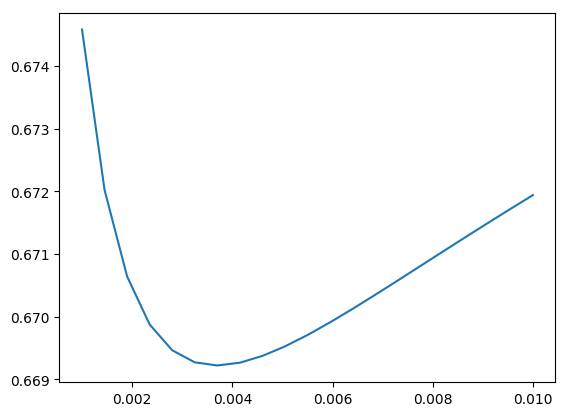

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f3ccfc82190>

In [9]:
# plot validation
plot(λ1_set, v1_set)

In [10]:
ind = indmin(v1_set);
λ1 = λ1_set[ind];
x1 = x1_set[ind];
@show λ1;

λ1 = 0.0037


### Test Data

In [11]:
@show logloss(x1, test_f, test_s);

logloss(x1,test_f,test_s) = 0.6964267561491205


## Problem 4: FISTA
Fill in the blanks to implement the FISTA algorithm to solve logistic regression problem,
$$\min_x \sum_{i=1}^m\left\{\log\left(1+\exp{\left\langle f_i, x\right\rangle}\right) - s_i\left\langle f_i,x\right\rangle\right\} + \lambda g(x)$$
Choose your favorite $g$ and try to get the test error as low as possible.

In [18]:
# Define functions
function lgr_g_func(x, f, s, λ)
    # TODO: pick your g and give your function
    return lgr_func(x, f, s) + λ*(0.5*norm(x,1) + 0.5*norm(x,2))
end

function prox_g(x, κ)
    # TODO: implement prox of g
    for I in eachindex(x)
        if x[I] > (0.5*κ)
            x[I] = (x[I]-(0.5*κ))/(1.0 + κ)
        elseif x[I] <(-0.5*κ) 
            x[I] = (x[I]+(0.5*κ))/(1.0 + κ) 
        else
            x[I] = 0.0;
        end
    end
end

prox_g (generic function with 1 method)

In [28]:
# define solvers
function FISTA(x, f, s, λ, func, prox; itm = 200, tol = 1e-6, pf = 1000)
    # TODO: Implement FISTA algorithm
    #step 1: initialize
    y  = copy(x);
    y_1 = copy(y);
    a  = 1.0;
    step_size  = (4.0/(norm(f,2)^2));
    g  = lgr_grad(x, f, s);
    obj = 0.0;
    err = 1.0;
    
    #step 2: until converge
    for i = 1:itm
       
        #step 3 : next value
        y = x - (step_size*g);
        prox(y, λ*step_size); 
        
        #step 4: compute alpha / second term
        a_next = 0.5*(1.0 + sqrt(1.0 + 4.0*a^2));
        sec_term  = (a - 1.0)/a_next;
        
        #step 5:
        for I in eachindex(x)
            x[I] = y[I] + sec_term*(y[I] - y_1[I]);
        end
        
        
        obj = func(x, f, s, λ);
        err = vecnorm(y - y_1);
        g   = lgr_grad(x, f, s);
        
        #step 6:
        a   = a_next;
        y_1 = copy(y);
        i % pf == 0 && @printf("iter %d, obj %1.5e, err %1.5e\n", i, obj, err);
        err < tol && break;
    end
    
    #output
    return x
end

FISTA (generic function with 1 method)

In [29]:
λ2_set = collect(linspace(0.01,0.001,11));
x2_set = [zeros(n_features) for i = 1:length(λ2_set)];
v2_set = zeros(length(λ2_set));
xcopy = zeros(n_features);
for i = 1:length(λ2_set)
    λ2 = λ2_set[i];
    x2 = x2_set[i];
    i > 1 && copy!(x2, x2_set[i-1]);
    println("λ2 = ", λ2, "=====================");
    FISTA(x2, train_f, train_s, λ2, lgr_g_func, prox_g; itm=100000, tol=1e-6, pf = 1000);
    v2_set[i] = logloss(x2, validate_f, validate_s);
end

λ2 = 0.01=====================
iter 1000, obj -4.96331e+03, err 3.48418e-03
iter 2000, obj -4.91433e+03, err 6.07819e-04
iter 3000, obj -4.91511e+03, err 2.12622e-04
iter 4000, obj -4.91448e+03, err 7.90038e-05
iter 5000, obj -4.91393e+03, err 3.10798e-05
iter 6000, obj -4.91439e+03, err 1.80256e-05
iter 7000, obj -4.91431e+03, err 8.58214e-06
iter 8000, obj -4.91433e+03, err 3.69893e-06
iter 9000, obj -4.91434e+03, err 2.19612e-06
λ2 = 0.0022=====================
iter 1000, obj -7.74146e+03, err 2.92822e-04
iter 2000, obj -7.74459e+03, err 5.47579e-05
iter 3000, obj -7.74412e+03, err 2.21950e-05
iter 4000, obj -7.74414e+03, err 9.78832e-06
iter 5000, obj -7.74418e+03, err 3.94446e-06
iter 6000, obj -7.74417e+03, err 1.92656e-06
λ2 = 0.0017=====================
iter 1000, obj -1.09263e+04, err 3.47383e-04
iter 2000, obj -1.09338e+04, err 6.34329e-05
iter 3000, obj -1.09340e+04, err 3.19046e-05
iter 4000, obj -1.09342e+04, err 1.22347e-05
iter 5000, obj -1.09340e+04, err 6.19023e-06
ite

iter 48000, obj -8.17232e+04, err 1.59264e-06
iter 49000, obj -8.17232e+04, err 1.39857e-06


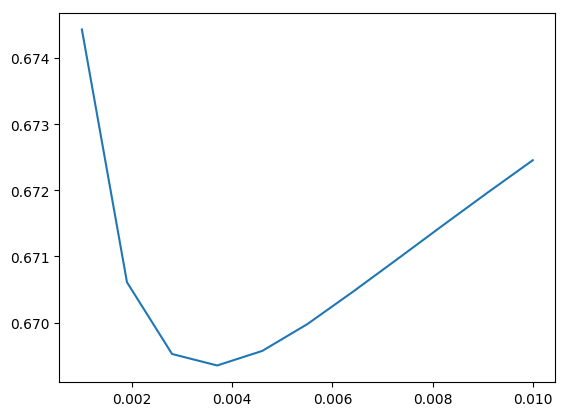

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f3ccf84c110>

In [30]:
plot(λ2_set, v2_set)

In [31]:
ind = indmin(v2_set);
λ2 = λ2_set[ind];
x2 = x2_set[ind];
@show λ2
@show logloss(x2, test_f, test_s);

λ2 = 0.0037
logloss(x2,test_f,test_s) = 0.6961375012799439
